## Summary 

Author: Trenton Bricken

Calls implementations of the Hopfield and various SDM models found in Associative_Memory_Implementations.py. 

Testing how well they can autoassociatively reconstruct random patterns and the MNIST dataset. 

Results are presented and analyzed in the paper Appendix.

Highly parallelized for more efficient computations.

In [1]:
%load_ext autoreload
%autoreload 2
from Implementations_Associative_Memory import *
from Data_Processing_Associative_Memory import *
from SDM_Circ_Inter_Funcs import space_frac_to_hamm_dist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm
from scipy.sparse import csc_matrix, coo_matrix, csr_matrix
import pandas as pd
import time
import copy
import pickle

In [2]:
# init multiprocessing using max number of CPUs available. Used to accelerate
# the Hamming distance calculations.
import ray
import psutil
num_cpus = psutil.cpu_count(logical=False)
print("num cpus", num_cpus)


num cpus 10


In [3]:
ray.init(num_cpus=num_cpus-5) # think it might be faster with just 1 CPU...

{'node_ip_address': '10.32.68.156',
 'raylet_ip_address': '10.32.68.156',
 'redis_address': '10.32.68.156:6379',
 'object_store_address': '/tmp/ray/session_2021-10-25_14-30-49_564129_812355/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-10-25_14-30-49_564129_812355/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-10-25_14-30-49_564129_812355',
 'metrics_export_port': 45596,
 'node_id': 'a7ed9deaf0178af0cb027315a35fa47eda9240404ec83ae92cd3715a'}

In [31]:
pattern_dataset = "RandUnif" # RandUnif, MNIST
rand_unif_n=1000 #64 or 1000
use_Neuron_SDM = False # will significantly reduce the number of neurons available. 
directory = 'figures/PerturbResults/'

cfracs = [0.0000000000001, 0.000000001, 0.00000001,0.000007, 0.000368, 0.1]
max_iterations =100 # for convergence of each query. 
# in the actual implementation convergence will stop when the previous 
# and current query are the same (has reached a fixed point).
n_datasets = 5
n_repeats = 10
print_each_result = False

if pattern_dataset == "MNIST":
    n=784 # MNIST sets this to image size.
    max_perturb = 300
    m=1024
    r = 1000000
elif pattern_dataset == "RandUnif":
    if rand_unif_n==64:
        n=64
        max_perturb = 12#8 #8 #20 #375
        r = 2**n#100000#2**n#1000000#2^n
        m=1024
    elif rand_unif_n==1000:
        # if dont want to perturb set to be 0.
        n=1000#64#64 #100
        max_perturb = 375#14#8 #8 #20 #375
        r = 1000000#2**n#100000#2**n#1000000#2^n
        m=1024

# Decide what functions should be run. 
if use_Neuron_SDM:
    r = 100000
    m = 1024
    functions = [Pattern_SDM_NeuronLimit, Neuron_SDM ]
else: 
    functions = [ Continuous_SDM, Binary_SDM_Attention, SDM_Attention, Pattern_SDM, Pattern_SDM_NeuronLimit] 

'''
# Full list of algorithms
[Pattern_SDM, Pattern_SDM_NeuronLimit,
Hopfield, 
Binary_SDM_Attention, SDM_Attention, Transformer_Attention,
Neuron_SDM] # run last as its the slowest. '''

'\n# Full list of algorithms\n[Pattern_SDM, Pattern_SDM_NeuronLimit,\nHopfield, \nBinary_SDM_Attention, SDM_Attention, Transformer_Attention,\nNeuron_SDM] # run last as its the slowest. '

In [5]:
# debugger (ray pool doesnt give meaningful error statements): 
'''raw_patterns_flat, target_patterns, \
        ham_dist_queries, cosine_dist_queries, perturb_hamms, h_dists, \
        image, image_len, correlated_dists = generate_dataset(pattern_dataset, 
                                                    n, m, max_perturb, cfracs, n_repeats)
h_dist=447
params = (n, r, m, h_dist, max_iterations, image_len, print_each_result)


converged_queries = Continuous_SDM(params, raw_patterns_flat,  
                        (ham_dist_queries, cosine_dist_queries), 
               plot=True, image=False, enforce_num_neurons=False)
'''


'raw_patterns_flat, target_patterns,         ham_dist_queries, cosine_dist_queries, perturb_hamms, h_dists,         image, image_len, correlated_dists = generate_dataset(pattern_dataset, \n                                                    n, m, max_perturb, cfracs, n_repeats)\nh_dist=447\nparams = (n, r, m, h_dist, max_iterations, image_len, print_each_result)\n\n\nconverged_queries = Continuous_SDM(params, raw_patterns_flat,  \n                        (ham_dist_queries, cosine_dist_queries), \n               plot=True, image=False, enforce_num_neurons=False)\n'

In [5]:
# iterate over the number of patterns. 
from ray.util.multiprocessing import Pool

# this is independent of the random dataset used
h_dists = space_frac_to_hamm_dist(n,cfracs)

pool_inputs = []
print("Generating the datasets:")
for dataset_num in range(n_datasets):
    # need to generate new random patterns which will affect convergence results. 
    #print("Dataset number is:", dataset_num)

    raw_patterns_flat, target_patterns, \
        ham_dist_queries, cosine_dist_queries, perturb_hamms, h_dists, \
        image, image_len, correlated_dists = generate_dataset(pattern_dataset, 
                                                    n, m, max_perturb, cfracs, n_repeats)
    for h_ind, h_dist in enumerate(h_dists):
        params = (n, r, m, h_dist, max_iterations, image_len, print_each_result)
        for fn in functions:
            plot=False
            image=False

            payload = (fn, params, raw_patterns_flat, target_patterns, 
                       dataset_num, (ham_dist_queries, cosine_dist_queries), plot, image )
            pool_inputs.append( payload  )
                
print("number of jobs", len(pool_inputs))
pool = Pool()
parallel_func_converged_results = pool.map(parallel_pool_caller, pool_inputs, 1)
print("running pool close")
pool.close()
pool.join()

# saving out the global retrieval dict: enables plotting everything at a later time. 
save_str = pattern_dataset+"|"+"ALLRayPoolOutputs|n="+str(n)+"m="+str(m)+"r="+str(r)+"datareps="+str(n_datasets)+"sampreps="+str(n_repeats)
with open(directory+save_str+".pkl", 'wb') as fname: 
    pickle.dump(parallel_func_converged_results, fname)
            
        

Generating the datasets:
perturbations are: [ 0  2  4  7  9 12]
hdists are: [5, 9, 11, 15, 19, 27]
perturbations are: [ 0  2  4  7  9 12]
hdists are: [5, 9, 11, 15, 19, 27]
perturbations are: [ 0  2  4  7  9 12]
hdists are: [5, 9, 11, 15, 19, 27]
perturbations are: [ 0  2  4  7  9 12]
hdists are: [5, 9, 11, 15, 19, 27]
perturbations are: [ 0  2  4  7  9 12]
hdists are: [5, 9, 11, 15, 19, 27]
number of jobs 60


(pid=812478) /home/trenton/SDM/SDM_Circ_Inter_Funcs.py:238: RuntimeWarning: divide by zero encountered in log
(pid=812478)   expected_intersect = np.log(intersect)+np.log(perc_addresses_w_neurons)
(pid=812478) /home/trenton/SDM/Implementations_Associative_Memory.py:648: RuntimeWarning: invalid value encountered in true_divide
(pid=812478)   res = res/intersects.sum()
(pid=812478) /home/trenton/SDM/Implementations_Associative_Memory.py:87: RuntimeWarning: invalid value encountered in greater
(pid=812478)   return (X>0.5).astype(bool)
(pid=812480) /home/trenton/SDM/SDM_Circ_Inter_Funcs.py:238: RuntimeWarning: divide by zero encountered in log
(pid=812480)   expected_intersect = np.log(intersect)+np.log(perc_addresses_w_neurons)
(pid=812480) /home/trenton/SDM/Implementations_Associative_Memory.py:648: RuntimeWarning: invalid value encountered in true_divide
(pid=812480)   res = res/intersects.sum()
(pid=812480) /home/trenton/SDM/Implementations_Associative_Memory.py:87: RuntimeWarning: in

running pool close


In [32]:
load_results = True

if load_results:
    save_str = pattern_dataset+"|"+"ALLRayPoolOutputs|n="+str(n)+"m="+str(m)+"r="+str(r)+"datareps="+str(n_datasets)+"sampreps="+str(n_repeats)

    with open(directory+save_str+".pkl", 'rb') as fname: 
        parallel_func_converged_results = pickle.load(fname)


In [38]:
h_dists = space_frac_to_hamm_dist(n, cfracs)
h_dists

[384, 405, 411, 431, 447, 480]

In [39]:
# score the performance from each output

# triply nested dictionary:
# used to store results
dataset_dict = {dataset_num:[] for dataset_num in range(n_datasets)}
h_dist_dict = {h_dist:copy.deepcopy(dataset_dict) for h_dist in h_dists}
global_retrieval_dict = {k.__name__:copy.deepcopy(h_dist_dict) for k in functions}

for parallel_func_res in parallel_func_converged_results: 
    converged_queries, target_patterns, fn, h_dist, dataset_num = parallel_func_res
    fn_name = fn.__name__
    if (fn_name == 'SDM_Attention' or fn_name=='Transformer_Attention') or fn_name == 'Continuous_SDM':
        sol_type = 'cont'
        #print(fn_name, fn, converged_queries)
    else: 
        sol_type = 'bin'

    #if print_each_result:
    #print('Function being run is:', fn_name)

    #converged_queries = fn(params, raw_patterns_flat, queries, plot=False, image=False)

    for i in range(len(converged_queries)):

        sol = converged_queries[i]
        target_pattern = target_patterns[i]

        if sol_type =='bin':
            target_pattern_bin = (target_pattern>0).astype(int) 
            sol = (sol>0).astype(int)
            res_dist = hamm_to_cosine(n-(sol==target_pattern_bin).sum(), n)
            if print_each_result:
                print('percentage agreement between solution and query no perturb',
                      p_agree)

        elif sol_type=='cont':
            epsilon = 0.05 # removes any rounding error in computing the similarity.
            p_agree = np.logical_and(target_pattern-epsilon < sol , 
                                 target_pattern+epsilon > sol).sum()/n
            
            res_dist = (target_pattern / np.linalg.norm(target_pattern)).T @ (sol / np.linalg.norm(sol))
        global_retrieval_dict[fn_name][h_dist][dataset_num].append(res_dist)

Continuous_SDM
d 384 mean [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
d 405 mean [0.9999999999999991, 0.9999999999998256, 0.9999999999999991, 0.9999999999999991, 0.999999999999999, 0.9999999999999989]
d 411 mean [0.9999999999999232, 0.9999999999909341, 0.9999999999999156, 0.9999999999999202, 0.9999999999999141, 0.999999999999855]
d 431 mean [0.9999999722513092, 0.999999198859426, 0.9999910230148221, 0.9999737012091825, 0.999999950528226, 0.999999939799079]
d 447 mean [0.9999062568474909, 0.9995664994578111, 0.9998482192612266, 0.9996783668421088, 0.9998643033247012, 0.9997707439049889]
d 480 mean [0.027102714937870725, 0.025792726223245067, 0.03696680786144877, 0.027120136395385547, 0.03414947896609143, 0.03361865511156669]


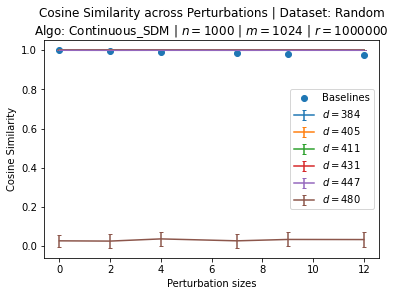

Binary_SDM_Attention
d 384 mean [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
d 405 mean [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
d 411 mean [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
d 431 mean [1.0, 1.0, 1.0, 1.0, 1.0, 0.9579599999999999]
d 447 mean [1.0, 1.0, 1.0, 1.0, 0.2776, 0.09871999999999997]
d 480 mean [0.05675999999999999, 0.05268, 0.0658, 0.04564, 0.04728000000000001, 0.03768000000000001]


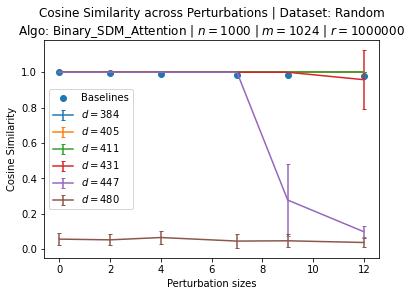

SDM_Attention
d 384 mean [1.0, 0.999999999999999, 1.0, 1.0, 1.0, 1.0]
d 405 mean [0.9999999999992245, 0.9999999998505615, 0.9999999999992162, 0.9999999999992272, 0.9999999999991168, 0.9999999999793338]
d 411 mean [0.9999999999729254, 0.9999999970151368, 0.9999999999726461, 0.9999999999727237, 0.9999999999642674, 0.9999999999729383]
d 431 mean [0.999999059814173, 0.9999797852964453, 0.9995731639421206, 0.999998677498187, 0.9999964964113272, 0.9999982390514844]
d 447 mean [0.9991810682862752, 0.9990300987735925, 0.998920462151943, 0.9987354452967171, 0.6587716563094922, 0.031308672958783354]
d 480 mean [0.02716910745618113, 0.026157731854999377, 0.03683511463733751, 0.02744256836192597, 0.03411801628330562, 0.03378821974329625]


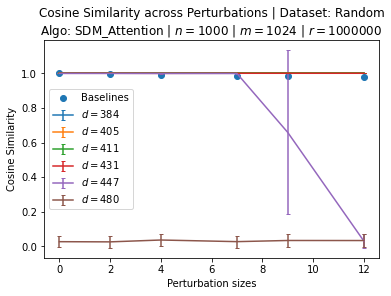

Pattern_SDM
d 384 mean [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
d 405 mean [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
d 411 mean [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
d 431 mean [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
d 447 mean [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
d 480 mean [0.07831999999999999, 0.07111999999999999, 0.08016, 0.05587999999999999, 0.05632000000000001, 0.04328000000000001]


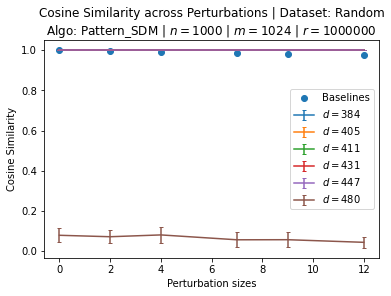

Pattern_SDM_NeuronLimit
d 384 mean [0.0020000000000000018, -0.0038400000000000036, 0.012680000000000004, -0.00692000000000001, -0.0017200000000000015, -0.00036000000000000474]
d 405 mean [0.0020000000000000018, -0.0038400000000000036, 0.012680000000000004, -0.00692000000000001, -0.0017200000000000015, -0.00036000000000000474]
d 411 mean [0.0020000000000000018, -0.0038400000000000036, 0.012680000000000004, -0.00692000000000001, -0.0017200000000000015, -0.00036000000000000474]
d 431 mean [1.0, 1.0, 0.44408000000000003, 0.19651999999999997, 0.02312, -0.00044000000000000484]
d 447 mean [1.0, 1.0, 1.0, 1.0, 1.0, 0.019080000000000003]
d 480 mean [0.07831999999999999, 0.07111999999999999, 0.08032, 0.05603999999999999, 0.056560000000000006, 0.04328000000000001]


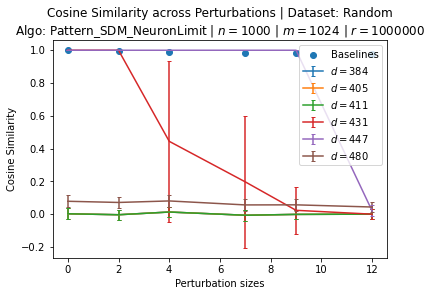

In [40]:
# runs after all the dataset loops. 
# averages across them. 

# need to account for fact hopfield may not be in every hdist. 
functions_to_use = copy.copy(functions)
if h_ind>0 and "Hopfield" in functions_to_use: 
    functions_to_use.remove('Hopfield')

for fn in functions_to_use: 
    fn_name = fn.__name__
    print(fn_name)
    for h_ind, h_dist in enumerate(h_dists):
        mus, stds = [], []
        # take the same slice across all of the datasets to pool the results and then compute the mean and std. 
        for i in range(len(perturb_hamms)):
            temp = []
            for dataset_num in range(n_datasets):
                data_res = global_retrieval_dict[fn_name][h_dist][dataset_num]
                temp.append( data_res[i*n_repeats:(i+1)*n_repeats] )
            mus.append(np.mean(temp))
            stds.append(np.std(temp))

        stds = np.asarray(stds) #np.stack([np.asarray(stds), np.zeros((len(stds)))])
        plt.errorbar(perturb_hamms, mus, yerr=stds,capsize=2, label="$d=$"+str(h_dist), alpha=1.0) #fmt='o', markersize=8, capsize=20)
        print('d', h_dist, 'mean', mus)
    
    plt.scatter(perturb_hamms, hamm_to_cosine(np.asarray(perturb_hamms),n), label='Baselines')
            
    plt.xlabel("Perturbation sizes")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    if pattern_dataset=='RandUnif':
        d_pretty = "Random"
    else: 
        d_pretty = pattern_dataset
    if n==64 and not use_Neuron_SDM:
        plt.title('Cosine Similarity across Perturbations | Dataset: '+d_pretty+"\n"+'Algo: '+fn_name+ " | $n=$"+str(n)+" | $m=$"+str(m)+ " | $r=2^n$")
    else: 
        plt.title('Cosine Similarity across Perturbations | Dataset: '+d_pretty+"\n"+'Algo: '+fn_name+ " | $n=$"+str(n)+" | $m=$"+str(m)+ " | $r=$"+str(r))

    save_str = pattern_dataset+"|"+str(fn_name)+"|n="+str(n)+"m="+str(m)+"r="+str(r)+"datareps="+str(n_datasets)+"sampreps="+str(n_repeats)
    plt.gcf().savefig(directory+save_str+'.png', dpi=250)
    plt.show()